In [265]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import json
from collections import Counter

wsbdf = None
stocksdf = None
startdate = None
enddate = None

In [266]:
def get_benchmark_returns(start_date, end_date, benchmark='SPY'):
    """
    Calculate daily returns for SPY or MAG7.
    """
    try:
        if benchmark == 'SPY':
            tickers = 'SPY'
            auto_adjust = True
        elif benchmark == 'MAG7':
            tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "NVDA", "META", "TSLA"]
            auto_adjust = True
        else:
            raise ValueError(f"Unknown benchmark: {benchmark}")
        
        data = yf.download(
            tickers,
            start=start_date,
            end=end_date,
            auto_adjust=auto_adjust,
            progress=False
        )
        
        if data.empty:
            return pd.Series(dtype=float)
        
        if benchmark == 'SPY':
            returns = data['Close'].pct_change().fillna(0) * 100
        else:  # MAG7
            prices = data["Close"]
            stock_returns = prices.pct_change().dropna() * 100
            # weigh each stock equally and take the mean
            returns = stock_returns.mean(axis=1)
            returns.name = "MAG7_Equal_Weighted_Return"
        
        # remove timezone for safety
        if hasattr(returns.index, 'tz_localize'):
            returns.index = returns.index.tz_localize(None)
        
        return returns
    
    except Exception as e:
        print(f"Error fetching {benchmark} data: {e}")
        return pd.Series(dtype=float)


In [267]:
def get_top_trades(results_dict):
    """
    Print top-5 longs and shorts per strategy (aggregated across holding periods).
    """
    for strat in ['wsb', 'stocks']:
        longs = []
        shorts = []
        for _, results in results_dict.items():
            trades = results.get(strat, {}).get('trades', [])
            for t in trades:
                ticker = t.get('ticker')
                direction = (t.get('direction') or '').upper()
                if not ticker:
                    continue
                if direction == 'LONG':
                    longs.append(ticker)
                elif direction == 'SHORT':
                    shorts.append(ticker)
        long_counts = Counter(longs)
        short_counts = Counter(shorts)
        
        print(f"\n{strat} trade frequency (top 5 longs):")
        for ticker, count in long_counts.most_common(5):
            print(f"  {ticker}: {count}")
            
        print(f"{strat} trade frequency (top 5 shorts):")
        for ticker, count in short_counts.most_common(5):
            print(f"  {ticker}: {count}")

In [268]:
def plot_results(results_dict):
    """
    Plot daily and cumulative returns
    """
    global wsbdf, stocksdf, start_date, end_date
    holding_periods = sorted(results_dict.keys())
    
    # colors
    colors = {
        'r/wallstreetbets': '#0080ff', # Blue
        'r/Stocks': '#ff0080', # Pink
        'SPY': '#00aa00', # Green
        'Mag 7': '#ff8800' # Orange
    }
    
    for days in holding_periods:
        results = results_dict[days]
        
        wsb_df = pd.DataFrame(results['wsb']['daily_returns'])
        wsb_df['date'] = pd.to_datetime(wsb_df['date'])
        
        stocks_df = pd.DataFrame(results['stocks']['daily_returns'])
        stocks_df['date'] = pd.to_datetime(stocks_df['date'])
        # cache for external inspection if needed
        wsbdf = wsb_df
        stocksdf = stocks_df
        start_date = max(wsb_df['date'].min(), stocks_df['date'].min())
        end_date = min(wsb_df['date'].max(), stocks_df['date'].max())
        
        spy_returns = get_benchmark_returns(start_date, end_date, 'SPY')
        mag7_returns = get_benchmark_returns(start_date, end_date, 'MAG7')
        
        # list for easier comprehension when plotting
        strategies = [
            ('r/wallstreetbets', results['wsb'], colors['r/wallstreetbets']),
            ('r/Stocks', results['stocks'], colors['r/Stocks']),
            ('SPY', None, colors['SPY']),
            ('Mag 7', None, colors['Mag 7']),
        ]
        
        # Create separate figure for this holding period
        fig, (ax_daily, ax_cum) = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle(f'{days}-Day Holding Period', 
                     fontsize=16, fontweight='bold', y=0.98)
        
        # Daily Returns
        for name, data, color in strategies:
            if data is not None:
                df = pd.DataFrame(data['daily_returns'])
                df['date'] = pd.to_datetime(df['date'])
                df = df[(df['date'] >= start_date) & (df['date'] <= end_date)].sort_values('date')
                ax_daily.plot(df['date'], df['return'], label=name, color=color, 
                            linewidth=1.5, alpha=0.8)
            elif name == 'SPY':
                ax_daily.plot(spy_returns.index, spy_returns.values, label=name, 
                            color=color, linewidth=1.5, alpha=0.8)
            elif name == 'Mag 7' and not mag7_returns.empty:
                ax_daily.plot(mag7_returns.index, mag7_returns.values, label=name, 
                            color=color, linewidth=1.5, alpha=0.8)
        
        # Styling for daily returns plot
        ax_daily.set_title('Daily Returns', fontsize=13, fontweight='bold', pad=10)
        ax_daily.set_xlabel('')
        ax_daily.set_ylabel('Daily Return (%)', fontsize=11)
        ax_daily.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
        ax_daily.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
        ax_daily.grid(True, alpha=0.2, linestyle='--', linewidth=0.5)
        ax_daily.legend(loc='upper left', fontsize=9, framealpha=0.9)
        ax_daily.spines['top'].set_visible(False)
        ax_daily.spines['right'].set_visible(False)
        
        # Cumulative Returns
        for name, data, color in strategies:
            if data is not None:
                df = pd.DataFrame(data['daily_returns'])
                df['date'] = pd.to_datetime(df['date'])
                df = df[(df['date'] >= start_date) & (df['date'] <= end_date)].sort_values('date')
                df['cumulative'] = ((1 + df['return'] / 100).cumprod() - 1) * 100
                ax_cum.plot(df['date'], df['cumulative'], label=name, color=color, 
                          linewidth=2.5, alpha=0.9)
                print(f'{days}-day {name}: {df["cumulative"].iloc[-1]:+.2f}%')
            elif name == 'SPY':
                spy_cumulative = ((1 + spy_returns / 100).cumprod() - 1) * 100
                ax_cum.plot(spy_cumulative.index, spy_cumulative.values, label=name, 
                          color=color, linewidth=2.5, alpha=0.9)
            elif name == 'Mag 7' and not mag7_returns.empty:
                mag7_cumulative = ((1 + mag7_returns / 100).cumprod() - 1) * 100
                ax_cum.plot(mag7_cumulative.index, mag7_cumulative.values, label=name, 
                          color=color, linewidth=2.5, alpha=0.9)
        
        
        # Styling for cumulative returns plot
        ax_cum.set_title('Cumulative Returns', fontsize=13, fontweight='bold', pad=10)
        ax_cum.set_xlabel('')
        ax_cum.set_ylabel('Cumulative Return (%)', fontsize=11)
        ax_cum.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
        ax_cum.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
        ax_cum.grid(True, alpha=0.2, linestyle='--', linewidth=0.5)
        ax_cum.legend(loc='upper left', fontsize=9, framealpha=0.9)
        ax_cum.spines['top'].set_visible(False)
        ax_cum.spines['right'].set_visible(False)
        
        # Format y-axis to show percentage
        ax_cum.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:+.0f}%'))
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

In [269]:

def calculate_correlations(results_dict):
    """Calculate correlation matrix and accuracy metrics for predicting SPY up/down days."""
    
    for days in sorted(results_dict.keys()):
        results = results_dict[days]
        
        # Load strategy data
        wsb_df = pd.DataFrame(results['wsb']['daily_returns'])
        wsb_df['date'] = pd.to_datetime(wsb_df['date'])
        
        stocks_df = pd.DataFrame(results['stocks']['daily_returns'])
        stocks_df['date'] = pd.to_datetime(stocks_df['date'])
        
        # keep interval of common dates
        start_date = max(wsb_df['date'].min(), stocks_df['date'].min())
        end_date = min(wsb_df['date'].max(), stocks_df['date'].max())
        
        spy_returns = get_benchmark_returns(start_date, end_date, 'SPY')
        mag7_returns = get_benchmark_returns(start_date, end_date, 'MAG7')
        
        # Trim strategies
        wsb_df = wsb_df[(wsb_df['date'] >= start_date) & (wsb_df['date'] <= end_date)].sort_values('date')
        stocks_df = stocks_df[(stocks_df['date'] >= start_date) & (stocks_df['date'] <= end_date)].sort_values('date')
        
        corr_data = pd.DataFrame({
            'date': wsb_df['date'].values,
            'WSB': wsb_df['return'].values,
            'Stocks': stocks_df['return'].values,
        })
        
        spy_df = pd.DataFrame({
            'date': pd.to_datetime(spy_returns.index).normalize(), 
            'SPY': spy_returns.values.flatten()
        })
        corr_data = corr_data.merge(spy_df, on='date', how='inner')
        
        mag7_df = pd.DataFrame({
            'date': pd.to_datetime(mag7_returns.index).normalize(), 
            'Mag7': mag7_returns.values.flatten()
        })
        corr_data = corr_data.merge(mag7_df, on='date', how='inner')
        
        cols = ['WSB', 'Stocks', 'SPY']
        if 'Mag7' in corr_data.columns:
            cols.insert(2, 'Mag7')
        
        corr_matrix = corr_data[cols].corr()
        
        print(f"\n{'='*60}")
        print(f"CORRELATION MATRIX - {days}-Day Holding Period")
        print(f"{'='*60}")
        print(corr_matrix.round(3))
        print(f"\n{len(corr_data)} trading days")
        
        # Show how each strategy correlates with SPY
        print(f"\n--- Correlations with SPY ---")
        spy_corr = corr_matrix['SPY'].drop('SPY').sort_values(ascending=False)
        for strategy, corr in spy_corr.items():
            print(f"{strategy:10s}: {corr:+.3f}")
        
        print(f"\n--- SPY Direction Prediction Accuracy ---")
        spy_direction = (corr_data['SPY'] > 0).astype(int)
        
        for strategy in ['WSB', 'Stocks']:
            if strategy not in corr_data.columns:
                continue
            
            strategy_direction = (corr_data[strategy] > 0).astype(int)
            
            # Count matches
            correct = (spy_direction == strategy_direction).sum()
            total = len(spy_direction)
            accuracy = correct / total if total > 0 else 0

            print(f"\n{strategy}:")
            print(f"  Overall Accuracy: {accuracy:.1%} ({correct}/{total})")



1-day r/wallstreetbets: +56.96%
1-day r/Stocks: -16.89%


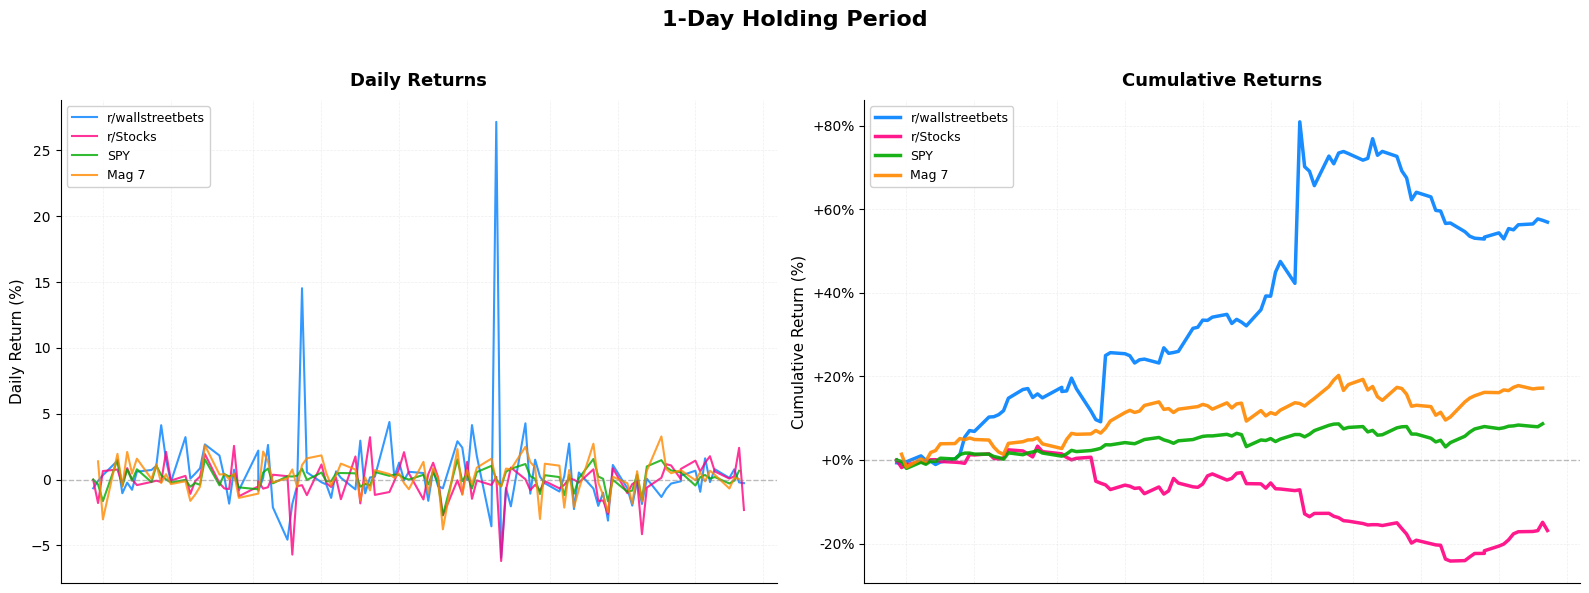

3-day r/wallstreetbets: -0.34%
3-day r/Stocks: +8.70%


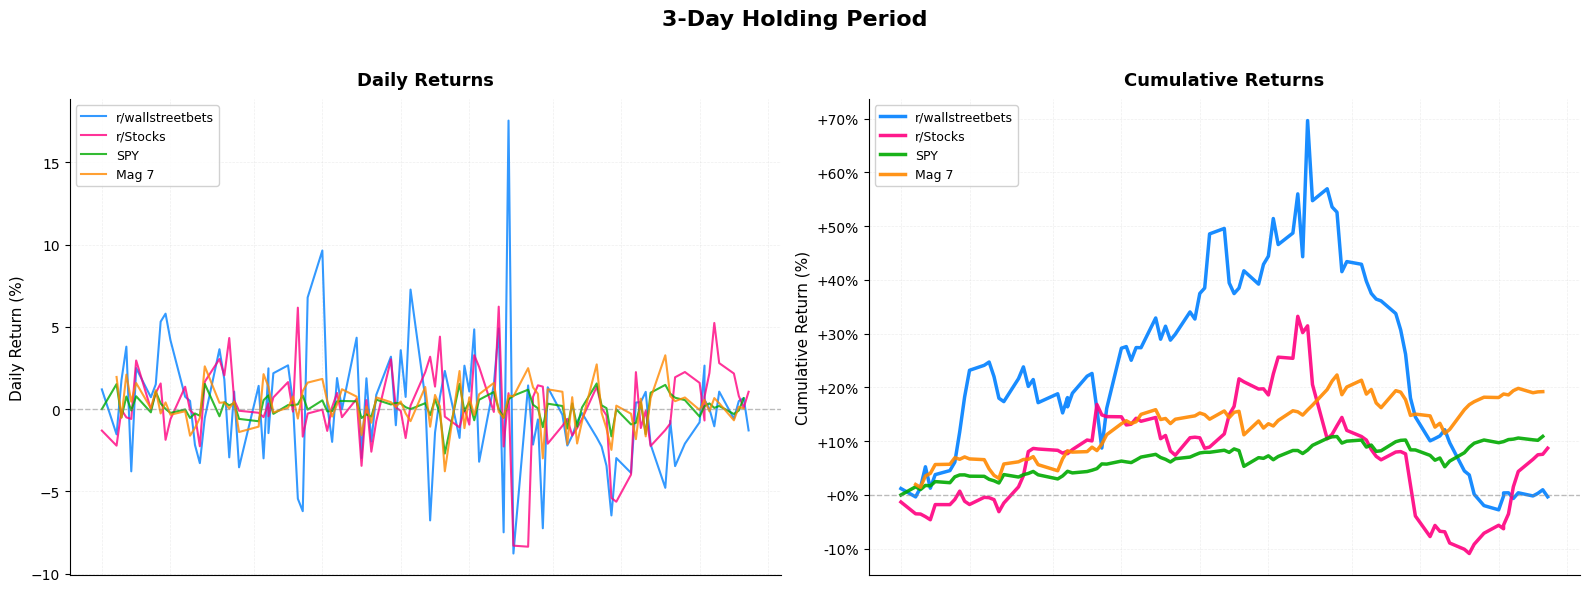

7-day r/wallstreetbets: +18.87%
7-day r/Stocks: +45.63%


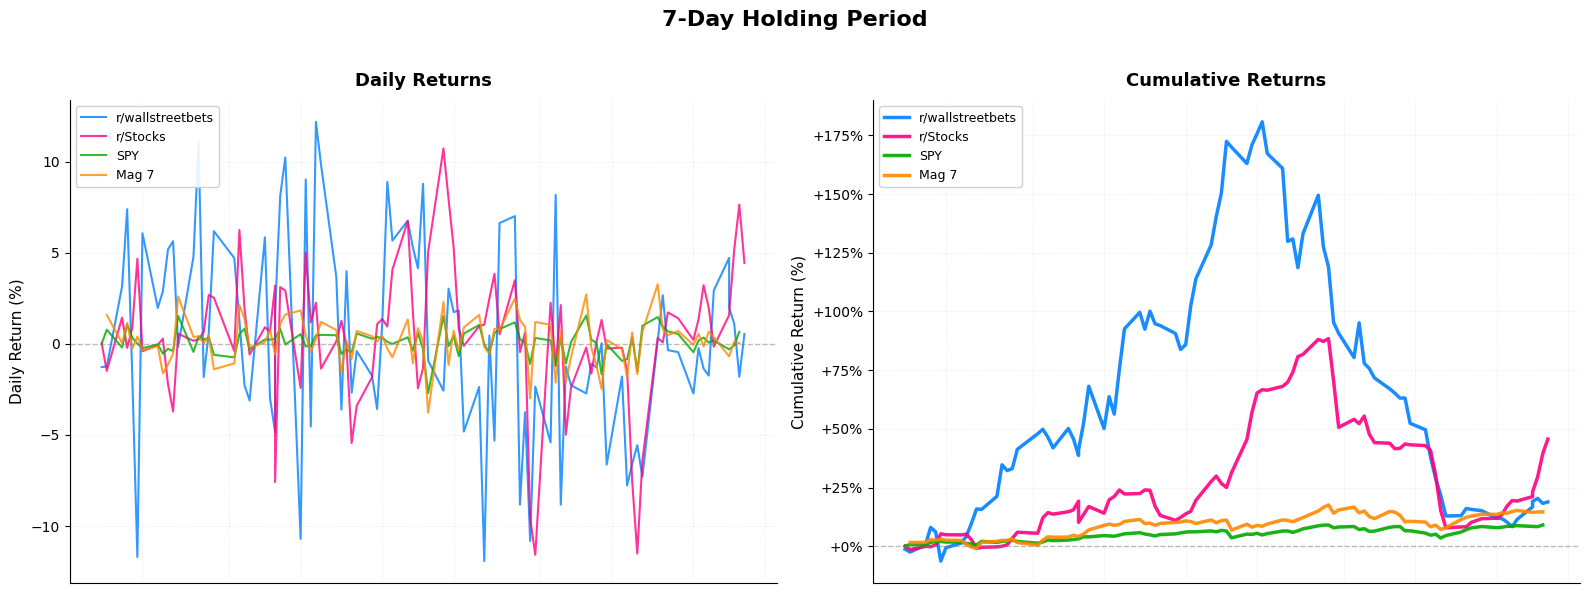

14-day r/wallstreetbets: +45.35%
14-day r/Stocks: +82.37%


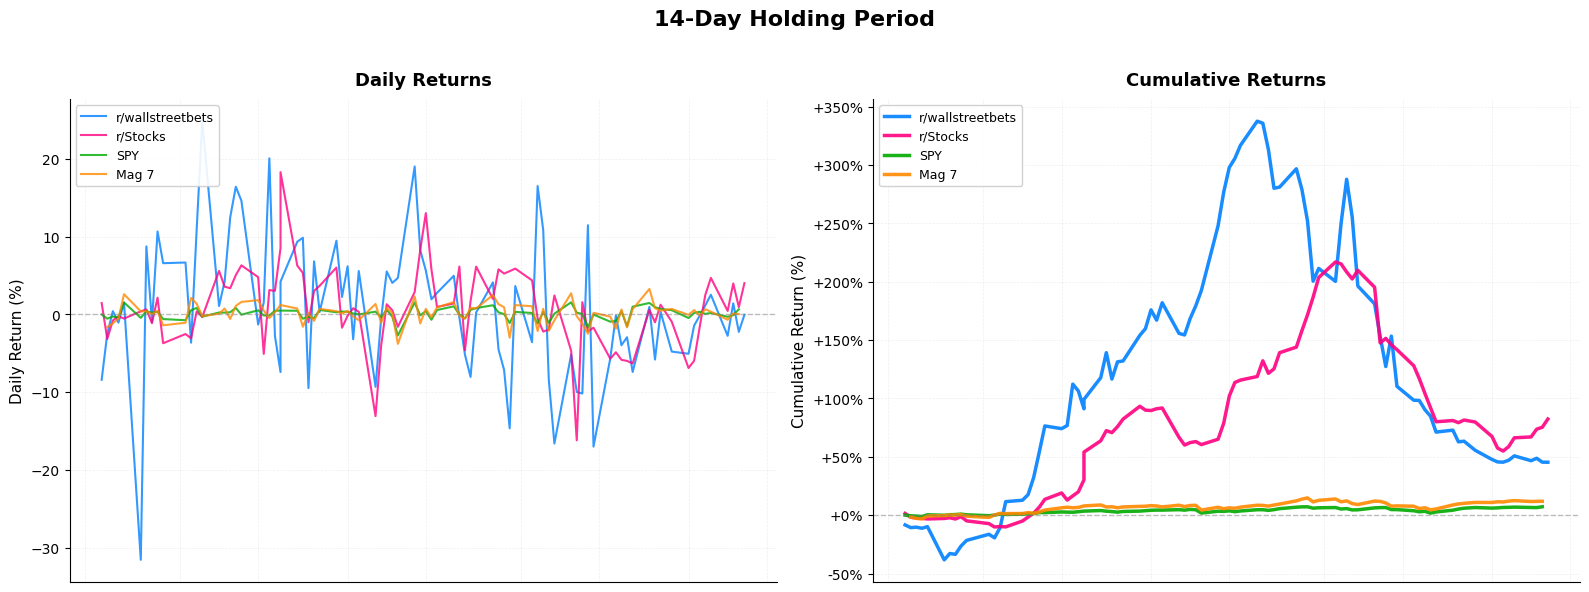


wsb trade frequency (top 5 longs):
  NVDA: 272
  TSLA: 214
  OPEN: 194
  QQQ: 193
  PLTR: 187
wsb trade frequency (top 5 shorts):
  TSLA: 199
  NVDA: 159
  AMD: 119
  OPEN: 119
  QQQ: 100

stocks trade frequency (top 5 longs):
  NVDA: 229
  AMD: 159
  GOOG: 159
  QQQ: 158
  PLTR: 134
stocks trade frequency (top 5 shorts):
  LINK: 129
  TSLA: 110
  QQQ: 78
  PLTR: 71
  NVDA: 68

CORRELATION MATRIX - 1-Day Holding Period
          WSB  Stocks   Mag7    SPY
WSB     1.000   0.146  0.095  0.132
Stocks  0.146   1.000  0.239  0.344
Mag7    0.095   0.239  1.000  0.872
SPY     0.132   0.344  0.872  1.000

95 trading days

--- Correlations with SPY ---
Mag7      : +0.872
Stocks    : +0.344
WSB       : +0.132

--- SPY Direction Prediction Accuracy ---

WSB:
  Overall Accuracy: 50.5% (48/95)

Stocks:
  Overall Accuracy: 54.7% (52/95)

CORRELATION MATRIX - 3-Day Holding Period
          WSB  Stocks   Mag7    SPY
WSB     1.000   0.230  0.157  0.061
Stocks  0.230   1.000 -0.035 -0.002
Mag7    0.157 

In [270]:
holding_days = [1, 3, 7, 14]
results_dict = {}
for days in holding_days:
    with open(f'backtests/backtest_results_{days}day.json', 'r') as f:
        results_dict[days] = json.load(f)

plot_results(results_dict)
get_top_trades(results_dict)
calculate_correlations(results_dict)